In [1]:
import os
import glob
import math

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from data_processing.record_feature_description import features_description

%matplotlib inline
%config InlineBackend.figure_format='retina'

2024-12-01 20:49:22.947371: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 20:49:22.949102: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 20:49:22.980682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 20:49:22.981225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 20:49:23.417317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
url_template = 'gs://waymo_open_dataset_motion_v_1_3_0/uncompressed/tf_example/training/training_tfexample.tfrecord-{:05d}-of-01000'
raw_data_dir = os.path.join(os.getcwd(), "raw_data")

if os.path.isdir(raw_data_dir):
    print(f"Directory '{raw_data_dir}' exists.")
else:
    print(f"Directory '{raw_data_dir}' does not exist, creating...")
    os.makedirs(raw_data_dir)

Directory '/home/yashas/Documents/gt/cs4644/motion-forecasting/raw_data' exists.


### Define utility functions

In [3]:
def filter_stationary_trajs(trajs: np.ndarray, stol: float = 1e-6) -> np.ndarray:
    valid_mask = trajs[:, :, -1] == 1
    trajs = trajs * valid_mask[:, :, None]
    stationary_mask = np.all(np.sqrt(trajs[:, :, 3]**2 + trajs[:, :, 4]**2) < stol, axis=1)
    return trajs[~stationary_mask]

In [4]:
def parse_single_tfrecord(record: bytes, fields: list[str]) -> np.ndarray:
    """Parses a single tfrecord file into a numpy array."""
    parsed = tf.io.parse_single_example(record, features_description)
    vehicle_mask = (parsed["state/type"] == 1)
    concat_features = []

    for field in fields:
        timeranges = (parsed[f"state/past/{field}"].numpy(), parsed[f"state/current/{field}"].numpy(), parsed[f"state/future/{field}"].numpy())
        feat = np.concatenate(timeranges, axis=1)
        concat_features.append(feat[vehicle_mask])

    out_trajs = np.stack(concat_features, axis=2)
    return filter_stationary_trajs(out_trajs)

In [5]:
from scipy.interpolate import interp1d

def resample_traj_2d(timestamps: np.ndarray, traj: np.ndarray, valid_mask: np.ndarray, dt: float = 0.1) -> np.ndarray:
    """Resamples a 2D trajectory to have a fixed number of samples."""
    t_min, t_max = timestamps[valid_mask][0], timestamps[valid_mask][-1]
    num_samples = math.ceil((t_max - t_min) / (dt * 1e6))
    target_timestamps = np.linspace(t_min, t_max, num=num_samples)

    interpolated_features = []
    for i in range(traj.shape[1]):
        interp_func = interp1d(timestamps[valid_mask], traj[valid_mask][:, i], kind="cubic", fill_value="extrapolate")
        interpolated_features.append(interp_func(target_timestamps))

    interpolated_features = np.stack(interpolated_features, axis=1)
    return interpolated_features

In [6]:
def pad_traj_to_fixed_length(traj: np.ndarray, length: int) -> np.ndarray:
    """Left pads a trajectory to a fixed length with first timestep."""

    if traj.shape[0] >= length:
        return traj[:length]
    
    padding = np.tile(traj[0], (length - traj.shape[0], 1))
    return np.concatenate([padding, traj], axis=0)

### Construct dataset

To construct the dataset, we keep downloading TFRecord files from the WOMD Google Cloud bucket and applying our parse function until `n_datapoint` datapoints are constructed. Remember, we throw away datapoints that are not of type `vehicle` or are stationary.

After parsing a TFRecord and saving the parsed data into system memory, we delete the local file to save space. The files are quite large!

In [ ]:
datapoints = np.array([])
n_datapoints = 5000
record_index = 2
fields = ["timestamp_micros", "x", "y", "velocity_x", "velocity_y", "bbox_yaw", "valid"]

while datapoints.shape[0] < n_datapoints:
    url = url_template.format(record_index)
    record_index += 1

    # Download the file from GCS
    os.system('gsutil -m cp ' + url + ' ' + raw_data_dir)

    filename = os.path.join(raw_data_dir, os.path.basename(url))
    dataset = tf.data.TFRecordDataset([filename], compression_type="")

    # Parse the TFRecord and concatenate the data with the existing data
    parsed = parse_single_tfrecord(next(dataset.as_numpy_iterator()), fields)
    datapoints = parsed if datapoints.shape[0] == 0 else np.concatenate([datapoints, parsed], axis=0)

    # Remove the downloaded file. This is optional, but saves disk space.
    os.remove(filename)

Copying gs://waymo_open_dataset_motion_v_1_3_0/uncompressed/tf_example/training/training_tfexample.tfrecord-00002-of-01000...
/ [1/1 files][816.4 MiB/816.4 MiB] 100% Done   3.2 MiB/s ETA 00:00:00           
Operation completed over 1 objects/816.4 MiB.                                    
2024-12-01 21:12:21.295040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


(90, 5)
[[ 7.85684619e+03  5.83018827e+00 -7.82244876e-02 -1.29443109e-02]
 [ 7.85683830e+03  5.84095334e+00 -7.29998003e-02 -1.26685483e-02]
 [ 7.85683137e+03  5.85267281e+00 -7.44900547e-02 -1.24938620e-02]
 [ 7.85682347e+03  5.88237999e+00 -7.17462425e-02 -1.24892176e-02]
 [ 7.85681662e+03  5.91554510e+00 -6.18089737e-02 -1.20720157e-02]
 [ 7.85681068e+03  5.94076580e+00 -5.82370298e-02 -1.11655918e-02]
 [ 7.85680489e+03  5.95855097e+00 -4.69936151e-02 -1.02014847e-02]
 [ 7.85680141e+03  5.96984029e+00 -4.40641674e-02 -9.52951437e-03]
 [ 7.85679593e+03  5.97928233e+00 -4.45381169e-02 -8.64767875e-03]
 [ 7.85679218e+03  5.98336439e+00 -3.38533899e-02 -7.79222368e-03]
 [ 7.85678916e+03  5.97725764e+00 -3.11126982e-02 -7.00920959e-03]
 [ 7.85678583e+03  5.94622743e+00 -2.64442717e-02 -6.13484653e-03]
 [ 7.85678385e+03  5.92315147e+00 -2.19579933e-02 -5.17417070e-03]
 [ 7.85678155e+03  5.91166635e+00 -1.78799086e-02 -4.28601997e-03]
 [ 7.85678041e+03  5.86838581e+00 -2.03240200e-02 -3.9

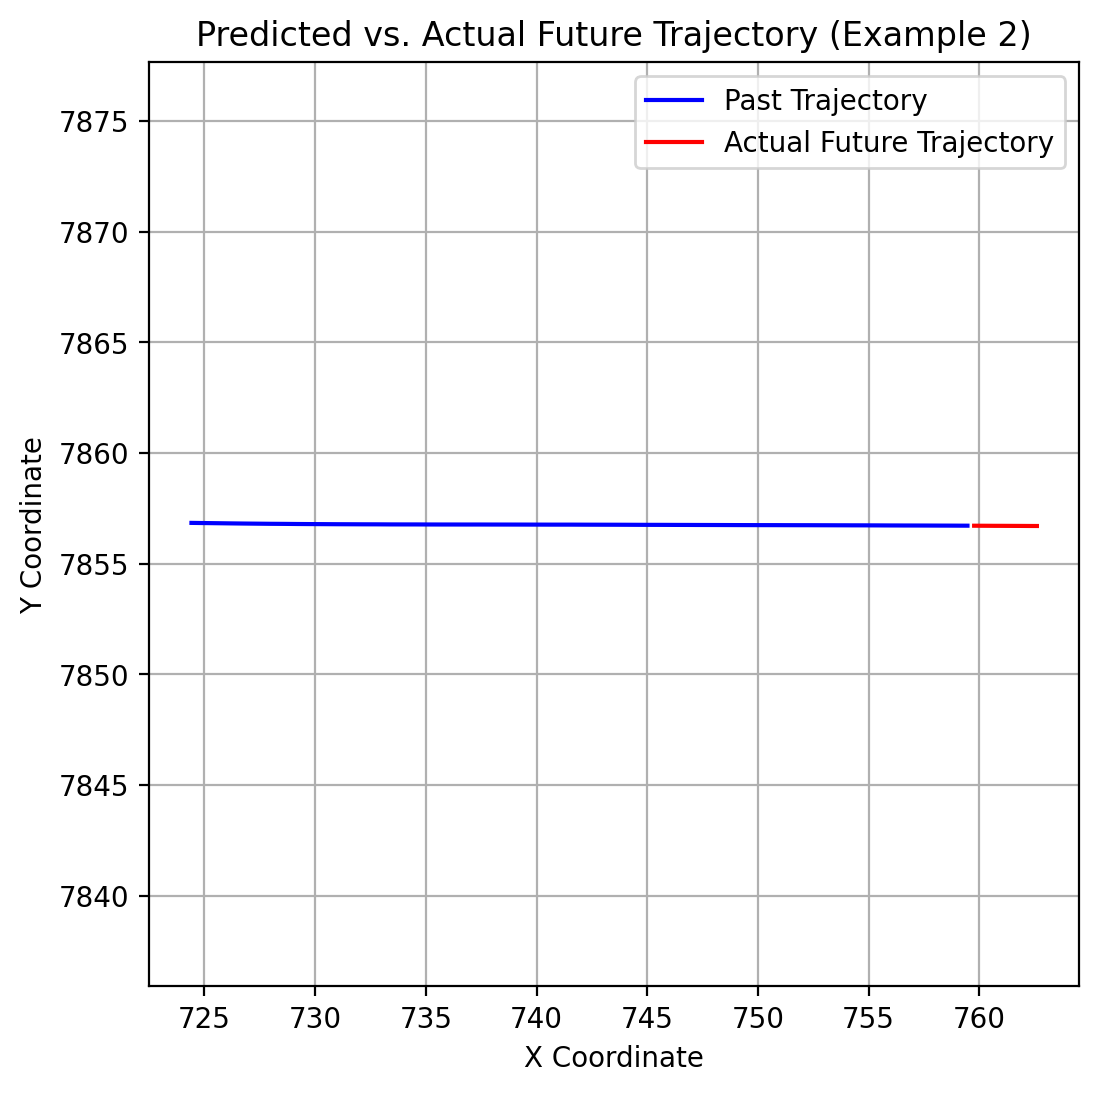

In [38]:
traj_index = 2
traj = valid_dps[traj_index]
resampled_traj = resample_traj_2d(traj[:, 0], traj[:, 1:6], valid_dps[traj_index][:, 6] == 1)

final_traj = pad_traj_to_fixed_length(resampled_traj, 90)

print(final_traj.shape)
print(final_traj[:, 1:6])

# Plot the past trajectory and the future trajectory
plt.figure(figsize=(6, 6))
plt.plot(final_traj[:80, 0], final_traj[:80, 1], label='Past Trajectory', color='blue')
plt.plot(final_traj[80:, 0], final_traj[80:, 1], label='Actual Future Trajectory', color='red')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {traj_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()